In [1]:

# coding: utf-8

# In[14]:

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt


class TwoPathConv3d(nn.Module):
    def __init__(self):
        super(TwoPathConv3d, self).__init__()
        self.local_conv1 = nn.Conv3d(3, 64, (7, 7, 3), padding = (16, 16, 0))
        self.local_conv2 = nn.Conv3d(64, 64, (3, 3, 3))
        self.local_conv3 = nn.Conv3d(3, 160, (13, 13, 5), padding = (16, 16, 0))
        self.total_conv = nn.Conv3d(224, 3, (21, 21, 1))

    def forward(self, x):
        under_x = F.relu(self.local_conv3(x))
        x = self.local_conv1(x)
        x = F.max_pool3d(F.relu(x), (4, 4, 1), stride = 1)
        x = self.local_conv2(x)
        x = F.max_pool3d(F.relu(x), (2, 2, 1), stride = 1)
        x = torch.cat((x, under_x), 1)
        x = self.total_conv(x)
        return x
        
import h5py
#challenge_f = h5py.File('Challenge.h5', 'r') #load challenge data

train_f = h5py.File('/home/yiqin/train/Unet-training.h5', 'r')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026", "HG/0027",]
"""
train_f = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]
"""
def create_test_batch(img = 0, z = 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:,:,:,z]
    batch.append(img1)
    batch = torch.from_numpy(np.array(batch))
    return batch

In [3]:
# TwoPathWay:
import time
import numpy as np
from torch.autograd import Variable
net = TwoPathConv3d()
net.load_state_dict(torch.load("/home/yiqin/3DTwopathway/phase2_TPW_net3d_2ch.txt"))
net = net.cuda(1)

In [6]:
"""def create_3D_batch(img = 0, z = 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    for i in range(z*5, z*5+9):
        img1 = train_f[case1][case2][:,:,:,i]
        batch.append(img1)
    batch = np.array(batch)
    batch = batch.transpose(1,2,3,0)
    temp = []
    temp.append(batch)
    batch = torch.from_numpy(np.array(temp))
    return batch"""

def create_3D_batch(img = 0, z = 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:3,:,:,z-2:z+3]
    batch.append(img1)
    batch = np.array(batch)
    batch = torch.from_numpy(batch)
    return batch

In [8]:
prev_time = time.clock()
#print(matrix_pred)
pred = {}

for i in range(len(SAMPLE)):
    img = SAMPLE[i]
    pred[img] = []
    case = SAMPLE[i]
    case1 = case[:2]
    case2 = case[3:]
    #_, X, Y, Z = challenge_f[case1][case2].shape
    _, X, Y, Z = train_f[case1][case2].shape
    print(X, Y, Z)
    '''
    for z in range(Z):
        x_batch = create_test_batch(img = i, z = z)
        x_batch = Variable(x_batch).cuda(1)
        y_pred = net.forward(x_batch)
        #y_pred = net.forward(x_batch)
        y_pred = y_pred.data.cpu().numpy()
        y_pred = y_pred.transpose(0,2,3,1)
        y_pred = np.reshape(y_pred, (-1, 5))
        pred[img].append(y_pred)
    '''
    tot = []
    for j in range(100,101):
        x_batch = create_3D_batch(i, j)
        x_batch = Variable(x_batch).cuda(1)
        y_pred = net.forward(x_batch)
        y_pred = y_pred.data.cpu().numpy()
        #print(y_pred.shape)
        y_pred = np.reshape(y_pred, (3, -1))
        y_pred = np.argmax(y_pred, axis = 0)
        y_pred = y_pred.reshape(X, Y)
        pred[img].append(y_pred)
        pred[img]=np.array(pred[img])
        
"""    
    pred[img] = np.array(pred[img])
    pred[img] = np.reshape(pred[img], (-1, 5))
    pred[img] = pred[img].argmax(axis = 1)
    pred[img] = np.reshape(pred[img], (-1, X, Y))
    pred[img] = pred[img].transpose(1, 2, 0)"""

216 196 176
216 236 176
216 236 176
159 216 196
216 236 176
162 230 230
230 230 165
168 220 220
162 230 230
230 230 163
160 216 176
160 216 176
176 216 176
160 216 176
160 216 176
216 236 176
176 216 176
160 216 176
160 216 176
160 216 176
176 216 176
176 216 176
176 216 176
176 216 176
160 216 176
230 230 165
168 240 240
162 230 230
168 220 220
162 230 230


'    \n    pred[img] = np.array(pred[img])\n    pred[img] = np.reshape(pred[img], (-1, 5))\n    pred[img] = pred[img].argmax(axis = 1)\n    pred[img] = np.reshape(pred[img], (-1, X, Y))\n    pred[img] = pred[img].transpose(1, 2, 0)'

160 216 176


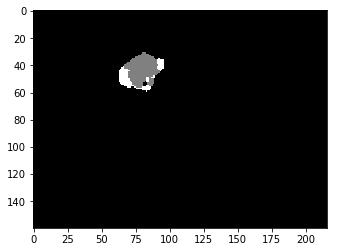

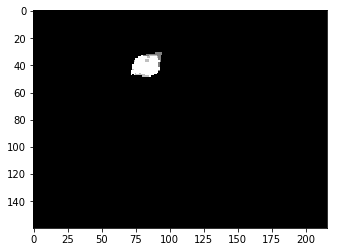

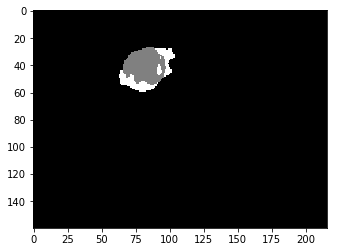

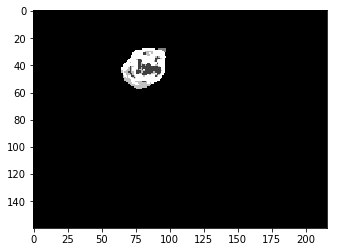

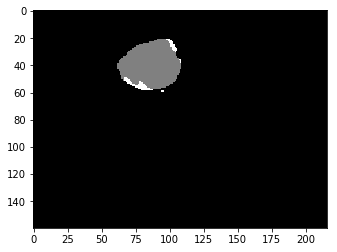

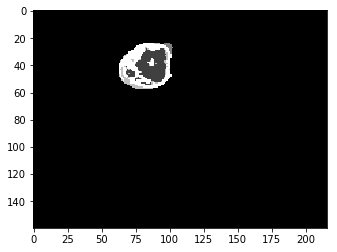

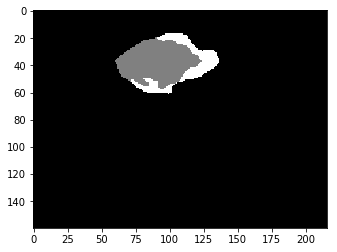

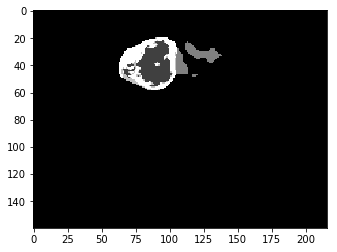

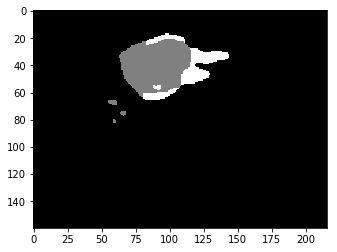

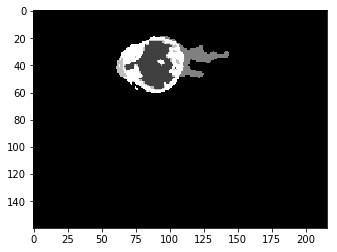

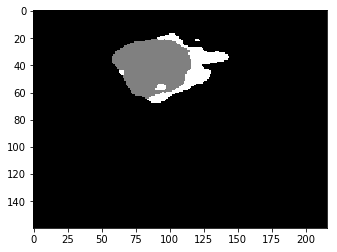

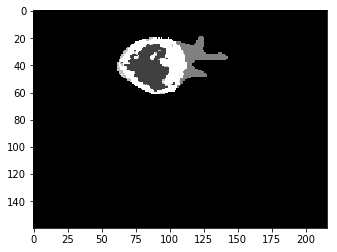

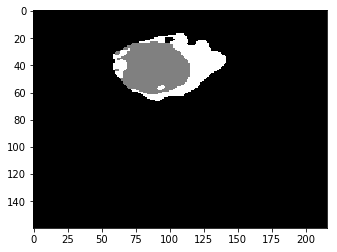

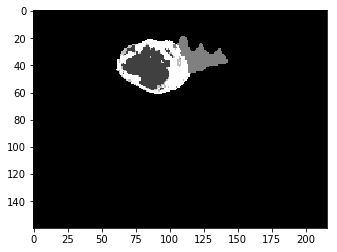

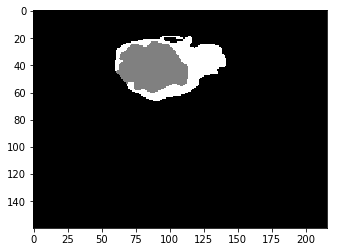

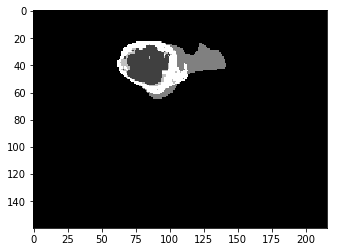

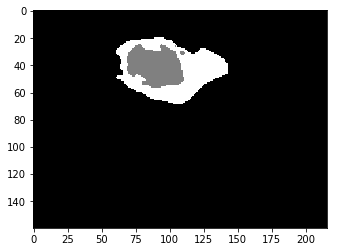

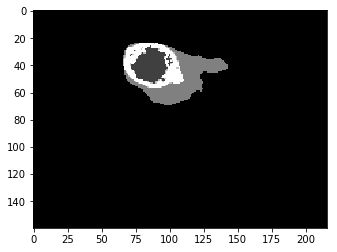

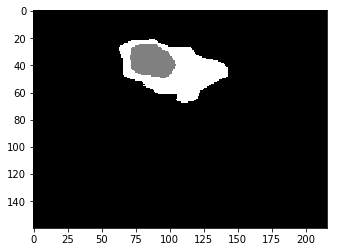

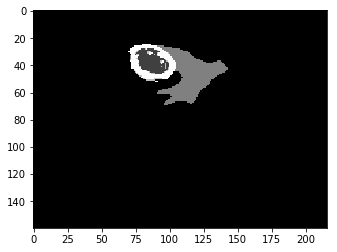

'    \n    pred[img] = np.array(pred[img])\n    pred[img] = np.reshape(pred[img], (-1, 5))\n    pred[img] = pred[img].argmax(axis = 1)\n    pred[img] = np.reshape(pred[img], (-1, X, Y))\n    pred[img] = pred[img].transpose(1, 2, 0)'

In [9]:
# Only look at HG0001

prev_time = time.clock()
#print(matrix_pred)
pred = {}
#for i in range(len(SAMPLE)):
for i in range(10,11):
    img = SAMPLE[i]
    pred[img] = []
    case = SAMPLE[i]
    case1 = case[:2]
    case2 = case[3:]
    #_, X, Y, Z = challenge_f[case1][case2].shape
    _, X, Y, Z = train_f[case1][case2].shape
    print(X, Y, Z)
    '''
    for z in range(Z):
        x_batch = create_test_batch(img = i, z = z)
        x_batch = Variable(x_batch).cuda(1)
        y_pred = net.forward(x_batch)
        #y_pred = net.forward(x_batch)
        y_pred = y_pred.data.cpu().numpy()
        y_pred = y_pred.transpose(0,2,3,1)
        y_pred = np.reshape(y_pred, (-1, 5))
        pred[img].append(y_pred)
    '''
    tot = []
    for j in range(50,100,5):
        x_batch = create_3D_batch(i, j)
        x_batch = Variable(x_batch).cuda(1)
        y_pred = net.forward(x_batch)
        y_pred = y_pred.data.cpu().numpy()
        y_pred = np.reshape(y_pred, (3, -1))
        y_pred = np.argmax(y_pred, axis = 0)
        y_pred = y_pred.reshape(X, Y)
        pred[img].append(y_pred)
        pred[img]=np.array(pred[img])
        
        array_img = pred[img]
        plt.imshow(array_img[0,:,:], cmap='gray')
        plt.show()
        plt.imshow(train_f['HG']['000%d'%(i - 9)][4,:,:,j], cmap = 'gray')
        plt.show()
        pred[img] = []
        
"""    
    pred[img] = np.array(pred[img])
    pred[img] = np.reshape(pred[img], (-1, 5))
    pred[img] = pred[img].argmax(axis = 1)
    pred[img] = np.reshape(pred[img], (-1, X, Y))
    pred[img] = pred[img].transpose(1, 2, 0)"""

(1, 159, 184)


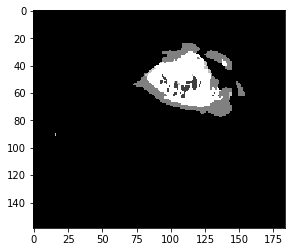

In [11]:
for img in range(2,3):
    array_img = pred[SAMPLE[img]]
    print(array_img.shape)
    #plt.imshow(matrix_pred[img][:,100,:], cmap='gray')
    plt.imshow(array_img[0,:,:], cmap='gray')
    plt.show()
    #plt.imshow(train_f['HG']['000%d'%(img - 9)][4,:,:,100], cmap = 'gray')
    #plt.show()

In [ ]:
for img in SAMPLE:
    print(pred[img].shape)

In [ ]:
import pickle
out_f = open('cas_net_challenge_pred.pkl','wb')
pickle.dump(pred, out_f)
out_f.close()

In [ ]:
import pickle
out_f = open('two_path_conv_challenge_pred.pkl','wb')
pickle.dump(pred, out_f)
out_f.close()

In [ ]:
import SimpleITK as sitk
import pickle

pkl_file = open('cas_net_challenge_pred.pkl', 'rb')
#pkl_file = open("two_path_conv_challenge_pred.pkl", 'rb')
pred_dict = pickle.load(pkl_file)
pkl_file.close()

ID = 17572
for i in range(len(SAMPLE)):
    img = SAMPLE[i]
    array_img = np.array(pred_dict[img], dtype = 'int16')
    array_img = array_img.transpose(2, 1, 0)
    out_img = sitk.GetImageFromArray(array_img)
    sitk.WriteImage(out_img, 'prediction-cas/VSD.P1_Seg_HG_30%d.%d.mha' %((i+1), ID + i*4))

In [ ]:
for s in SAMPLE:
    case1 = s[:2]
    case2 = s[3:]
    plt.imshow(pred_dict[s][:,:,100], cmap = 'gray')
    plt.show()
    for i in range(4):
        plt.imshow(train_f[case1][case2][i,:,:,100], cmap = 'gray')
        plt.show()

(140, 184, 159)


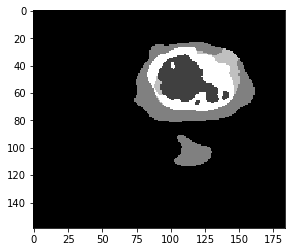

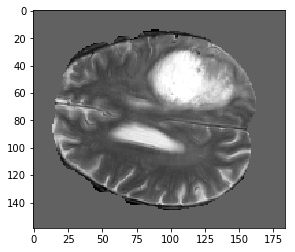

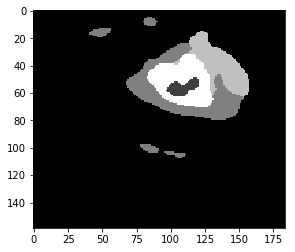

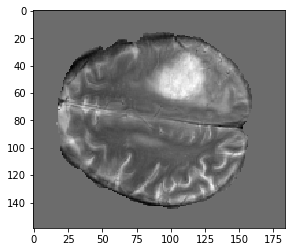

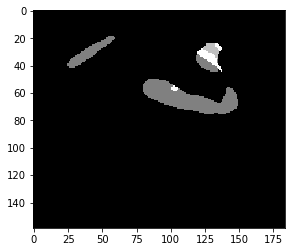

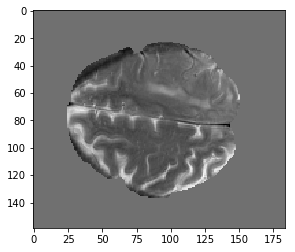

In [10]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
test_img = sitk.ReadImage('prediction-cas/VSD.P1_Seg_HG_303.17580.mha')
test_array = sitk.GetArrayFromImage(test_img)
print(test_array.shape)
for i in range(90, 120, 10):
    plt.imshow(test_array[i,:,:].transpose(1,0), cmap = 'gray')
    plt.show()
    plt.imshow(train_f['HG']['0303'][3,:,:,i], cmap = 'gray')
    plt.show()